# In Depth - Decision Trees and Forests

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

Here we'll explore a class of algorithms based on decision trees.
Decision trees at their root are extremely intuitive.  They
encode a series of "if" and "else" choices, similar to how a person might make a decision.
However, which questions to ask, and how to proceed for each answer is entirely learned from the data.

For example, if you wanted to create a guide to identifying an animal found in nature, you
might ask the following series of questions:

- Is the animal bigger or smaller than a meter long?
    + *bigger*: does the animal have horns?
        - *yes*: are the horns longer than ten centimeters?
        - *no*: is the animal wearing a collar
    + *smaller*: does the animal have two or four legs?
        - *two*: does the animal have wings?
        - *four*: does the animal have a bushy tail?

and so on.  This binary splitting of questions is the essence of a decision tree.

One of the main benefit of tree-based models is that they require little preprocessing of the data.
They can work with variables of different types (continuous and discrete) and are invariant to scaling of the features.

Another benefit is that tree-based models are what is called "nonparametric", which means they don't have a fix set of parameters to learn. Instead, a tree model can become more and more flexible, if given more data.
In other words, the number of free parameters grows with the number of samples and is not fixed, as for example in linear models.


## Decision Tree Classification

Decision tree classification work very similarly, by assigning all points within a leaf the majority class in that leaf:

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from figures import plot_2d_separator
from figures import cm2


X, y = make_blobs(centers=[[0, 0], [1, 1]], random_state=61526, n_samples=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

/home/lemaitre/Documents/code/toolbox/scikit-learn/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
pred

array([0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0])

We can plot the decision boundaries found using the training data.

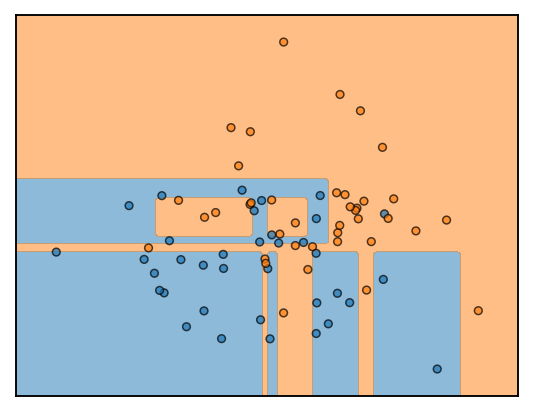

In [4]:
fig, ax = plt.subplots(figsize=(9, 7))
plot_2d_separator(clf, X, fill=True, ax=ax)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm2, s=60, alpha=.7, edgecolor='k');

Similarly, we get the following classification on the testing set.

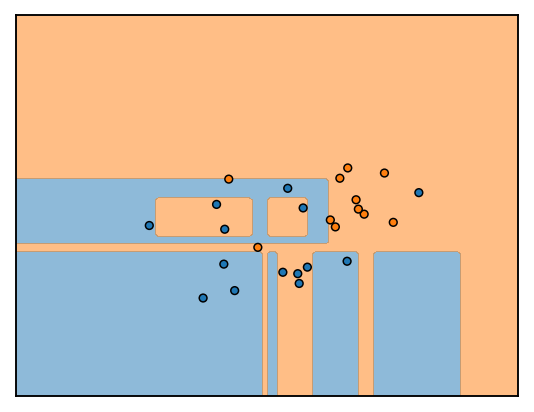

In [5]:
fig, ax = plt.subplots(figsize=(9, 7))
plot_2d_separator(clf, X, fill=True, ax=ax)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm2, s=60, edgecolor='k');

There are many parameter that control the complexity of a tree, but the one that might be easiest to understand is the maximum depth. This limits how finely the tree can partition the input space, or how many "if-else" questions can be asked before deciding which class a sample lies in.

This parameter is important to tune for trees and tree-based models. The interactive plot below shows how underfit and overfit looks like for this model. Having a ``max_depth`` of 1 is clearly an underfit model, while a depth of 7 or 8 clearly overfits. The maximum depth a tree can be grown at for this dataset is 8, at which point each leave only contains samples from a single class. This is known as all leaves being "pure."

In the interactive plot below, the regions are assigned blue and red colors to indicate the predicted class for that region. The shade of the color indicates the predicted probability for that class (darker = higher probability), while yellow regions indicate an equal predicted probability for either class.

### Exercise

**Modify the depth of the tree and see how the paritionning evolves.**

**What can you say about under- and over-fitting of the tree model?**

**How would you choose the best depth?**

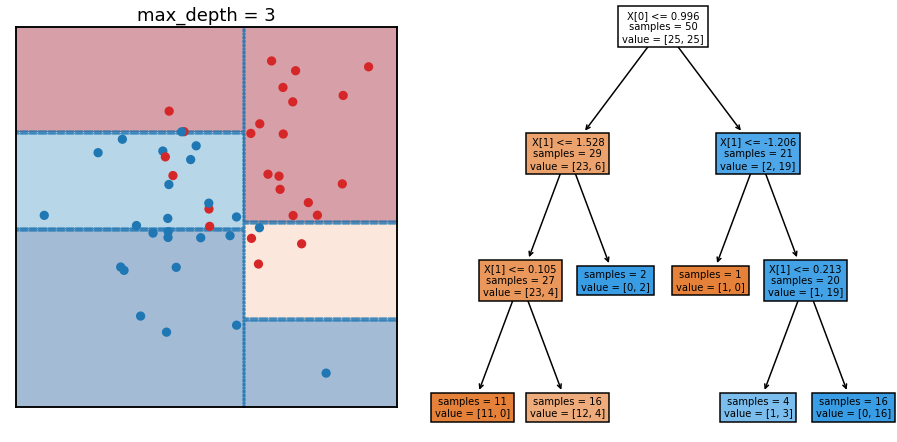

In [6]:
from figures import plot_tree
max_depth = 3

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
plot_tree(max_depth=max_depth, ax=ax)

## Decision Tree Regression

A decision tree is a simple binary classification tree that is
similar to nearest neighbor classification.  It can be used as follows:

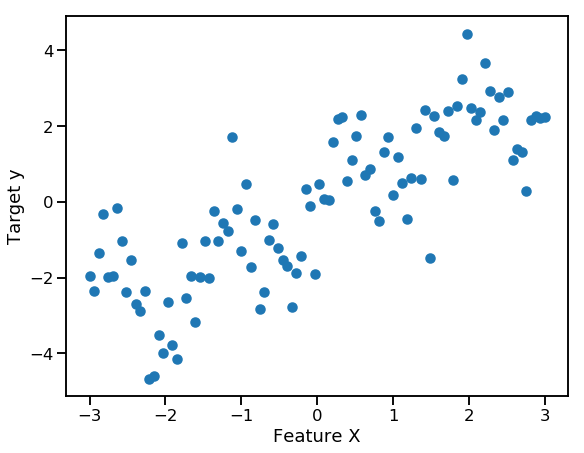

In [7]:
from figures import make_dataset
x, y = make_dataset()
X = x.reshape(-1, 1)

plt.figure(figsize=(9, 7))
plt.xlabel('Feature X')
plt.ylabel('Target y')
plt.scatter(X, y);

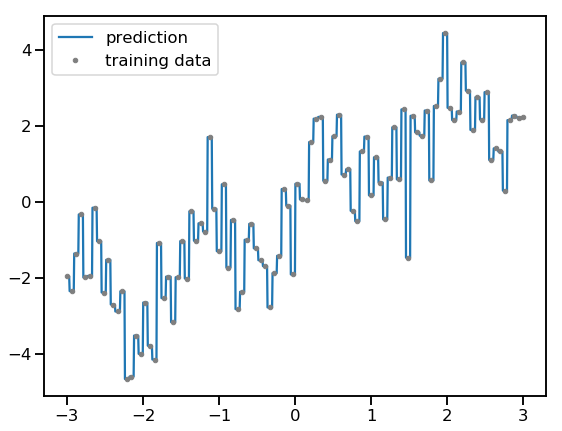

In [8]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=None)
reg.fit(X, y)

X_fit = np.linspace(-3, 3, 1000).reshape((-1, 1))
y_fit_1 = reg.predict(X_fit)

plt.figure(figsize=(9, 7))
plt.plot(X_fit.ravel(), y_fit_1, color='tab:blue', label="prediction")
plt.plot(X.ravel(), y, 'C7.', label="training data")
plt.legend(loc="best");

A single decision tree allows us to estimate the signal in a non-parametric way,
but clearly has some issues.  In some regions, the model shows high bias and
under-fits the data.
(seen in the long flat lines which don't follow the contours of the data),
while in other regions the model shows high variance and over-fits the data
(reflected in the narrow spikes which are influenced by noise in single points).

### Exercise

**Take the above example and repeat the training/testing by changing depth of the tree.**

**What can you conclude?**

## Bagging classifiers

We saw that by increasing the depth of the tree, we are going to get an over-fitted model. A way to bypass the choice of a specific depth it to combine several trees together.

Let's start by training several trees on slightly different data. The slightly different dataset could be generated by randomly sampling with replacement. In statistics, this called a boostrap sample. We will use the iris dataset to create such ensemble and ensure that we have some data for training and some left out data for testing.

In [9]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

Before to train several decision trees, we will run a single tree. However, instead to train this tree on `X_train`, we want to train it on a bootstrap sample. You can use the `np.random.choice` function sample with replacement some index. You will need to create a sample_weight vector and pass it to the `fit` method of the `DecisionTreeClassifier`. We provide the `generate_sample_weight` function which will generate the `sample_weight` array.

In [10]:
def generate_sample_weight(X):
    idx_bootstrap = np.random.choice(
        np.arange(X.shape[0]), size=X.shape[0], replace=True
    )
    weight = np.ones(X.shape[0])
    weight *= np.bincount(idx_bootstrap, minlength=X.shape[0])
    return weight

In [11]:
for _ in range(3):
    print(generate_sample_weight(X_train))

[1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 3. 2. 0. 1. 2. 0. 1. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 3. 1. 2. 1. 0. 1. 0. 0. 3. 0. 1. 1. 2. 1. 2. 1. 0. 1. 3. 1.
 0. 0. 1. 0. 0. 2. 1. 0. 0. 2. 1. 0. 0. 1. 4. 1. 0. 0. 3. 2. 1. 0. 0. 2.
 1. 2. 1. 3. 1. 1. 0. 1. 2. 1. 1. 1. 3. 3. 3. 1. 0. 1. 0. 2. 2. 0. 2. 0.
 0. 0. 1. 2. 1. 0. 1. 1. 0. 1. 1. 3. 2. 1. 0. 1.]
[2. 0. 0. 1. 1. 1. 1. 2. 1. 0. 0. 0. 2. 1. 1. 1. 1. 0. 2. 2. 2. 0. 1. 0.
 1. 0. 0. 3. 0. 2. 1. 0. 0. 1. 0. 0. 3. 1. 0. 0. 1. 1. 0. 0. 4. 0. 2. 1.
 1. 1. 2. 1. 0. 3. 0. 2. 0. 2. 0. 2. 1. 0. 1. 1. 2. 1. 4. 0. 3. 0. 1. 0.
 1. 3. 2. 2. 1. 1. 2. 0. 2. 0. 0. 0. 2. 0. 1. 0. 1. 3. 1. 1. 2. 2. 0. 1.
 0. 1. 1. 0. 0. 2. 1. 1. 2. 1. 1. 2. 0. 1. 0. 0.]
[0. 1. 2. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 2. 1. 0. 1. 0. 1. 1. 1. 0. 0.
 0. 1. 0. 0. 0. 2. 1. 1. 2. 1. 1. 1. 1. 0. 1. 0. 1. 2. 2. 2. 0. 0. 2. 2.
 2. 0. 1. 2. 1. 0. 1. 0. 2. 1. 1. 2. 2. 0. 2. 0. 0. 2. 2. 1. 2. 0. 1. 0.
 1. 2. 3. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 2. 2. 1. 3. 0. 2. 3. 1. 2. 0. 1.
 2. 0. 2. 1. 0. 1. 3. 1.

In [12]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train, sample_weight=generate_sample_weight(X_train))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Now, you can create several bootstrap samples and train several `DecisionTreeClassifier` which can be stored into a Python list.

In [13]:
n_trees = 100
forest = []
for _ in range(n_trees):
    sample_weight = generate_sample_weight(X_train)
    tree = DecisionTreeClassifier()
    forest.append(tree.fit(X_train, y_train, sample_weight=sample_weight))

Get the predictions of each trained `DecisionTreeClassifier` and combined them into a numpy array.

In [14]:
y_pred_forest = []
for tree in forest:
    y_pred_forest.append(tree.predict(X_test))

In [15]:
y_pred_forest = np.array(y_pred_forest).T

In [16]:
y_pred = []
for sample_pred in y_pred_forest:
    y_pred.append(np.bincount(sample_pred).argmax())

We can aggregate the vote of each `DecisionTreeClassifier` by taking the most frequent value.

In [17]:
np.mean(y_pred == y_test)

0.9473684210526315

Compute the accuracy score on the training and testing set.

In [18]:
from sklearn.ensemble import BaggingClassifier

In [19]:
clf = BaggingClassifier(n_estimators=100)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9473684210526315

Check the documentation of the `sklearn.ensemble.BaggingClassifier` in scikit-learn. It corresponds to what you implemented up to now.
Apply this classifier on the `digits` dataset and compare the results obtained with a single `sklearn.tree.DecisionTreeClassifier`.

## Random Forests

A very famous classifier is the random forest classifier. It is similar to the bagging classifier. In addition of the bootstrap, the random forest will use a subset of features (selected randomly) to find the best split.

In [20]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

Use your previous code which was generated several `DecisionTreeClassifier`. Check the list of the option of this classifier and modify one of the parameters such that only the $\sqrt{F}$ features are used for the splitting. $F$ represents the number of features in the dataset.

In [21]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from figures import plot_2d_separator
from figures import cm2


X, y = make_blobs(centers=[[0, 0], [1, 1]], random_state=61526, n_samples=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In scikit-learn, we can directly used the `sklearn.ensemble.RandomForestClassifier`.

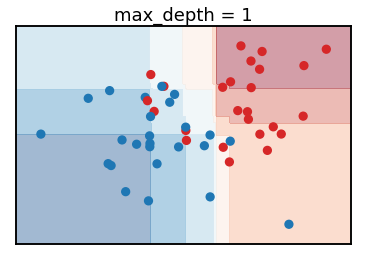

<function figures.plot_interactive_forest.plot_forest(max_depth=1)>

In [22]:
from ipywidgets import interact
from figures import plot_forest
max_depth = 3

plt.figure(figsize=(9, 7));
interact(plot_forest, max_depth=(1, 10))

## Selecting the Optimal Estimator via Cross-Validation

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestClassifier(n_estimators=200)
parameters = {'max_features':['sqrt', 'log2', 10],
              'max_depth':[5, 7, 9]}

clf_grid = GridSearchCV(rf, parameters, n_jobs=-1)
clf_grid.fit(X_train, y_train)

/home/lemaitre/Documents/code/toolbox/scikit-learn/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='deprecated',

In [24]:
clf_grid.score(X_train, y_train)

1.0

In [25]:
clf_grid.score(X_test, y_test)

0.9733333333333334

## Another option: Gradient Boosting

Another Ensemble method that can be useful is *Boosting*: here, rather than
looking at 200 (say) parallel estimators, We construct a chain of 200 estimators
which iteratively refine the results of the previous estimator.
The idea is that by sequentially applying very fast, simple models, we can get a
total model error which is better than any of the individual pieces.

In [26]:
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=.2)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9975520554767698
0.8595724811117564


<div class="alert alert-success">
    <b>EXERCISE: Cross-validating Gradient Boosting</b>:
     <ul>
      <li>
      Use a grid search to optimize the `learning_rate` and `max_depth` for a Gradient Boosted
Decision tree on the digits data set.
      </li>
    </ul>
</div>

In [27]:
from sklearn.datasets import load_digits
from sklearn.ensemble import GradientBoostingClassifier

digits = load_digits()
X_digits, y_digits = digits.data, digits.target

# split the dataset, apply grid-search

In [28]:
# %load solutions/18_gbc_grid.py

## Feature importance

Both RandomForest and GradientBoosting objects expose a `feature_importances_` attribute when fitted. This attribute is one of the most powerful feature of these models. They basically quantify how much each feature contributes to gain in performance in the nodes of the different trees.

In [29]:
X, y = X_digits[y_digits < 2], y_digits[y_digits < 2]

rf = RandomForestClassifier(n_estimators=300, n_jobs=1)
rf.fit(X, y)
print(rf.feature_importances_)  # one value per feature

[0.00000000e+00 6.99551659e-05 9.35454434e-04 7.99170153e-03
 4.55501148e-04 3.55886922e-03 2.94989420e-03 0.00000000e+00
 0.00000000e+00 2.73142198e-04 1.93769866e-02 3.69784039e-04
 2.56978382e-03 1.77406007e-03 3.88390257e-04 0.00000000e+00
 1.42527799e-04 1.15187017e-02 3.91388291e-03 3.05785619e-02
 5.98804482e-02 2.88587232e-03 1.00987752e-02 0.00000000e+00
 1.05358693e-04 1.43399230e-02 5.24253712e-04 5.76627958e-02
 1.38530075e-01 4.92012926e-03 6.90749020e-02 0.00000000e+00
 0.00000000e+00 2.81897329e-02 6.56354956e-03 4.48230473e-02
 1.56302770e-01 4.45712548e-03 7.83419891e-02 0.00000000e+00
 0.00000000e+00 1.87033477e-02 3.65948771e-02 1.60258565e-02
 8.51053315e-02 3.03183993e-03 3.00385297e-02 0.00000000e+00
 0.00000000e+00 3.66580556e-04 2.25320685e-02 4.96831123e-03
 1.20994063e-03 2.52015941e-03 8.23188762e-04 4.48469347e-04
 0.00000000e+00 0.00000000e+00 1.46981723e-03 6.98224222e-03
 4.43985410e-04 2.71851411e-03 2.44899532e-03 0.00000000e+00]


<BarContainer object of 64 artists>

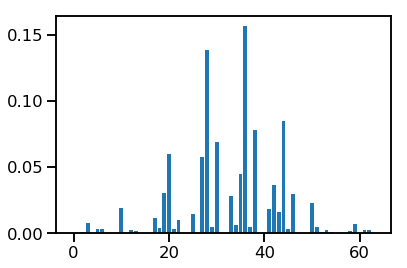

In [30]:
plt.bar(np.arange(rf.feature_importances_.size), rf.feature_importances_)

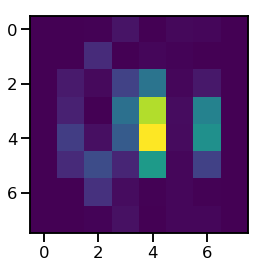

In [31]:
plt.figure()
plt.imshow(rf.feature_importances_.reshape(8, 8), cmap=plt.cm.viridis, interpolation='nearest')

### Be careful with feature importances

We will check that we should be careful when interpreting the feature importances when dealing with both numerical and categorical data. Let's take the case of the the titanic dataset.

In [32]:
import os
import pandas as pd

titanic = pd.read_csv(os.path.join('datasets', 'titanic3.csv'))
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [33]:
data = titanic[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
labels = titanic.survived.values

In [34]:
data.head()

,pclass,sex,age,sibsp,parch,fare,embarked
0,1,female,29.0000,0,0,211.3375,S
1,1,male,0.9167,1,2,151.5500,S
2,1,female,2.0000,1,2,151.5500,S
3,1,male,30.0000,1,2,151.5500,S
4,1,female,25.0000,1,2,151.5500,S


We will divide the data into a training and testing set.

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, stratify=labels, random_state=42
)

Having categorical and numerical data, we need to have a specific pipeline for the numerical columns and a specific pipeline for the categorical columns.

In [36]:
categorical_columns = ['pclass', 'sex', 'embarked']

In [37]:
numerical_columns = ['age', 'sibsp', 'parch', 'fare']

In [38]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

categorical_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore')
)

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

numerical_pipe = make_pipeline(
    StandardScaler(), SimpleImputer(strategy='mean')
)

We can use the `sklearn.compose.make_column_transformer` to combine both processing which will be automatically done when calling `fit()` or `transform()`.

In [40]:
from sklearn.compose import make_column_transformer

preprocessing_pipe = make_column_transformer(
    (categorical_pipe, categorical_columns),
    (numerical_pipe, numerical_columns)
)

Finally, we will use a `RandomForestClassifier` and use the feature importance to check either the numerical or the categorical data are more important.

In [41]:
from sklearn.ensemble import RandomForestClassifier
final_pipe = make_pipeline(preprocessing_pipe, RandomForestClassifier(random_state=42))

In [42]:
final_pipe.fit(X_train, y_train).score(X_test, y_test)

0.7865853658536586

In [43]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Relative feature importances')

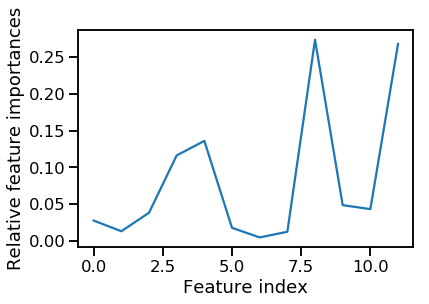

In [44]:
plt.plot(final_pipe.named_steps['randomforestclassifier'].feature_importances_)
plt.xlabel('Feature index')
plt.ylabel('Relative feature importances')

Currently, there is no easy way to `inverse_transform`. However, the last 4 features are the numerical features while the 8 first are the categorical features. Thus, it seems that the numerical features are more important. However, this is due to a bias because of the cardinality which is smaller for categorical data, leading to a reduce amount of split for those features. You can refer to: https://explained.ai/rf-importance/index.html

You can try to:

* use only the categorical features and check the classification performance;
* use only the numerical features and check the classification performance.